# Click Requests from a Single Campaign with Known BOT Activity


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
import pytz
from dateutil.tz import tzutc
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import display

df = pd.read_csv('C:/Users/youci/Documents/SingleCampaignClicksWithKnownBotActivity2.csv', 
                 parse_dates=['SendDate', 'RequestDate'],
                dtype = {'AS Number':str})  

# Clean up
df['AS Name'].fillna('Unknown', inplace=True)
df['AS Number'].fillna('Unknown', inplace=True)

# Calculated Columns
df['SendRequestLatency'] = df.RequestDate - df.SendDate

df['SendRequestSeconds'] = ((pd.to_datetime(df['RequestDate']) - 
                            pd.to_datetime(df['SendDate']))
                                .dt.total_seconds()).clip(lower=0).astype('int')

# df['RequestDateTZ'] = df['RequestDate'] \
#                           .dt.tz_localize('America/New_York') \
#                           .dt.tz_convert(df['OlsonName'].item)

# df['RequestDateTZ'] = df.apply(lambda x: 
#                                     x.RequestDate.dt.tz_localize('America/New_York')\
#                                                  .dt.tz_convert(pytz.timezone(x.OlsonName))
#                                  , axis=1)

## Terminology
- **Subscriber List** - A list of email addresses that have opted into receiving emails from the company.  A list have have many emails.  A company can have many subscriber lists.  An email can belong to many lists and many companies.  But a subscriber list can only belong to one company.
- **Campaign** - An email message send out by a company.  This email is sent to some or all the subscribers on the list.  With the exception of some limited personalization, all subscribed receive the same content.  A list can have many campaigns, but a campaign can only have one subscriber list.
- **Inbox** - What the contact sees as a unique message in their inbox (Outlook, GMail, etc.).  If a company sends a single campaign to 1 million contacts, there will be 1 million InboxIDs for that campaign.
- **Request** - A tracking HTTP request from an action the contact takes on a message in their inbox.  There are several types of requests, but they are primarily Opens which are pixel image reqeusts and Clicks.
- **Link** - A clickable and trackable URL embedded in the email message.  The tracking system identifies the click, saved the tracking information and returns a redirect URL so the contact gets to their intended URL destination.
- **AS Number/Name** - Who owns the block of IP address.  https://en.wikipedia.org/wiki/Autonomous_system_(Internet)
- **CIDR** - A notation of shows us what range of IP address are in a block. https://en.wikipedia.org/wiki/Classless_Inter-Domain_Routing


## Columns
 - **InboxID** - Uniquely identifies the Campaign and the email it was sent to.
 - **Company** - Who owns the campaign
 - **List** - A unique ID of the subscription list.  
 - **Campaign** - A unique ID of the campaign.
 - **RequestType** - 
     - *Open* - The contact downloaded images for the message.  A tracking pixel added to the HTML body of the message makes a request to the tracking system to identify who opened the message.
     - *Read* - The message was opened for a pre-defined period of time.
     - *Click* - The contact clicked on a URL in the message and the tracking system sees this request.
     - *Browser Link* - The contact requested seeing the message in a web browser.  Mostly used if the message did not render well in the email client.
 - **SendDate** - The date and time (1 minute precision) of when the message was sent to that email.  If a company sends a campaign to 5 million email, the send might take 10-20 mins.  The SendDate is the date when that message was sent out and not the date the campaign started.
 - **RequestDate** - The date of the reqeust (i.e. Open or Click).
 - **Link** - A hash of the URL requested.
 - **IPAddress** - The IP Address the requested was generated from.
 - **UserAgent** - A string submitted by email clients/browsers and Bots that attempts to identify the browser type.  This can be made any string you want to it can be easily modified by Bots.
 - **AS Name** - Owner of the IP Range (see above).  Can be Null if owner not found in ASN database.
 - **AS Number** - Owner of the IP Range (see above).  Can be Null if owner not found in ASN database.
 - **CIDR Range** - The block the IPAddress belongs to (see above).  Can be Null if owner not found in ASN database.
 - **UserID** - A unique ID of the email address the message was sent to.
 - **DomainID** - A unique ID of the domain of the email address the message was sent to.
 - **EmailDomain** (redundant with DomainID)- A unique ID of the domain of the email address the message was sent to.
 - **EmailRootLevelDomain** - The top level domain of the email domain.  i.e. fred@gamil.com - ".com", mary@harvard.edu - ".edu"
 - **Lat/Long** - Found from an IP Lookup service.  Data available is not center of mass, but just the first Lat/Log in the polygon.
 - **OlsonName** - Time Zone of the location the request came from. Also found via the IP Lookup.  
 - **SendRequestLatency** - timedelta between the time the message was sent to the request date.
 - **SendRequestSeconds** - Number of seconds between the time the message was sent to the request date..


In [2]:
df.nunique()

InboxID                 11566
Company                     1
List                        1
Campaign                    1
RequestType                 1
SendDate                   13
RequestDate              2187
Link                       37
IPAddress               10339
UserAgent                1181
AS Name                    21
AS Number                  22
CIDR Range                354
UserID                  11566
DomainID                  952
EmailDomain               952
EmailRootLevelDomain       32
CountryCode                77
RegionCode                148
PostalCode               2572
Lat                      1612
Long                     1659
OlsonName                  79
SendRequestLatency       2181
SendRequestSeconds       2180
dtype: int64

# Dummies?

In [3]:
pd.get_dummies(df['AS Name'])

,AT&T Mobility LLC,"Amazon.com, Inc.",Cellco Partnership DBA Verizon Wireless,"CenturyLink Communications, LLC",Cogent Communications,"Comcast Cable Communications, LLC","DigitalOcean, LLC",DoD Network Information Center,GENESCO INC,Google LLC,...,"Level 3 Parent, LLC","MCI Communications Services, Inc. Verizon Business",Microsoft Corporation,Scalair SAS,Shaw Communications Inc.,Sprint,"T-Mobile USA, Inc.",TELUS Communications Inc.,Unknown,Windstream Communications LLC
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
24054,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
24055,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
24056,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [4]:
pd.get_dummies(df['EmailRootLevelDomain'])

,.ac,.ar,.au,.be,.br,.ca,.cc,.ch,.co,.com,...,.net,.nz,.org,.pl,.ru,.sg,.studio,.uk,.us,.ws
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24053,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
24054,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
24055,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
24056,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
pd.get_dummies(df['UserAgent'])

,{00269E75-3556-AB9E-E9A4-F8C3ABE1AC41},{004F5B4C-D759-FDF3-E32B-FA4B83CD0FF5},{008ADD4F-6293-3BC9-A53B-807A135C1DE5},{00D2A8FD-BD12-4E6C-920C-F645BE8DE11C},{013045EC-A44F-7A05-ACFE-352A984F0A8A},{013F9ABA-F4CA-4CAD-4D69-B5DAC7F329F5},{0155F35C-F2F5-A2D0-1CBB-6047496BF3D3},{01720770-F593-A949-5CDD-F16A87289532},{0172191A-97A3-A3FF-C4CD-C23962A1B22B},{01DAEBAA-4C36-D3C6-5FD3-F2D03E294AA6},...,{FEF82A33-7407-9FC5-9597-4CCF59098B66},{FF0C10E4-3634-2DB8-A3B9-D7D3E5BC076D},{FF188D45-BD91-31EF-EC02-4B1A348C2E6C},{FF20A57D-E015-EEA0-444C-22C3BDF75FBF},{FF301957-2207-B86A-DAF8-DD101FCA64F2},{FF41AFE8-4861-FC9F-FB7C-DA9F5A74169B},{FF52E805-84FF-F684-588D-A7DBEF6D53AE},{FF7147BD-138B-1FE2-388E-61D3A87600E2},{FF8EFA11-63A9-DA22-7766-5A669CD3D547},{FFA16732-0D89-D188-2B67-1D7C7CA06106}
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24054,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24055,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24056,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Sessionization

 Making assessments from individual requests may not be as informative as grouping requests together.  It is not uncommon for a single InboxID to have multiple requests. For example, 20 minutes after a message was put into a contact's inbox, they might open the message (pixel request) followed by 3 or 4 link clicks.  That same contact might go back to that same message the following day and click on several more links.
 
It might be more suspicious that requests are from a BOT if 20 clicks come in for the same InboxID in under 3 seconds or if the same IP Address requests opens from 50 different InboxIDs in a short period of time.

There are 3 things needed to determine a session.  The first is how to partition or group the data.  The more obvious choices for this grouping is the InboxID, the IP Address and the combination of both the IP and Inbox.

The next thing needed is the some kind of time frame algorithm.  The algorithm chosen is to include all requests for the given partition as long at duration between requests doesn't exceed a set gap. This requires a datetime column (in case, the RequestDate) and a max gap allowed.

The method below is structure in a way to allow us to use different partitioning column(s) and to append a "session ID" to the existing dataframe as opposed to showing a single session per row with aggregate data.

In [6]:
def get_session_column(df, group_column_1, datetime_column, time_gap, session_column, group_column_2 = None):
    """
    This method returns a pandas series that holds "session id"
    
    df = The dataframe we will based the session on
    group_column_1 = The column name will we use to partition the data on
    datatime_column = The datetime column name we will use as the basis of the session
    time_gap = How long between sorted requests need to elapse before we create a new session
    session_column = The name we will give to the new session column
    group_column_2 (Optional) = A second column name we can use to partition the data on
    
    1) Make sue passed in df is stored by the datatime column
    2) Copy the necessary columns into a working dataframe
    3) Add a column that shows the last previous datetime for the partitioned data (NaT if no previous row)
    4) Add a column that determines if the current row is a new session (NaT or too big a gap in time)
    5) Add a column that uses cumsum() to create a LocalSessionID scoped to the partition
    6) Add a column that uses a hash to get a global SessionID
    7) Return just the series.  
    
    Because we make sure the passed in dataframe is sorted, 
        the index of the returned series matches the index of the passed in dataframe
    """
    
    # The dataframe must be stored by RequestDate since we are window functions on this order 
    if not (df.index.name == datetime_column and df.index.is_monotonic()):
        df.sort_values(datetime_column, inplace=True)
        
    # set column names (this sorts the passed in dataframe)
    lastColumnName = 'Last' + datetime_column
    group = group_column_1
    if group_column_2:
        group = [group_column_1, group_column_2]
        
    # select local dataframe (allows us to work only on a subset of the full dataframe)
    if group_column_2:
        working_df = df[[group_column_1, datetime_column, group_column_2]].copy()
    else:
        working_df = df[[group_column_1, datetime_column]].copy()         
    

    # Create a pandas series (column) grouping by SendID that holds the previous RequestDate for that SendID
    last = working_df.groupby(group)[datetime_column].transform(lambda x:x.shift(1))

    # Append the above column to the dataframe with a name of LastRequestDate
    working_df = pd.concat([working_df, last.rename(lastColumnName)], axis=1)

    # It is a new session if LastRequestDate is null or the LastRequestDate is less then T old
    # We cast the result as an int so we can use cumsum in the next step
    working_df['IsNewSession'] = np.logical_or(working_df[datetime_column] - working_df[lastColumnName] > time_gap, 
                                       working_df[lastColumnName].isnull()).astype(int)

    # Use cumnsum to get the session number within a specific SendID. Note: This is not yet a global session id
    working_df['LocalSessionID'] = working_df.groupby(group)['IsNewSession'].cumsum()

    # New create a global session ID by combining the group by value and the LocalSessionID
    if group_column_2:
        working_df[session_column] = (
                                            working_df[group_column_1].astype(str) + '|' 
                                            + working_df[group_column_2].astype(str) + '|' 
                                            + working_df['LocalSessionID'].astype(str)
                                     ).apply(hash)
    else:
        working_df[session_column] =  (
                                            working_df[group_column_1].astype(str) + '|' 
                                            + working_df['LocalSessionID'].astype(str)
                                      ).apply(hash)
        
    return working_df[session_column]

## Extend Dataframe

Append 3 new columns to the df:
1. Partitioned by InboxID only - Same inbox message, but from any "computer".
2. Partitioned by IPAddress only - Same "computer", but from any inbox message.
3. Partitioned by InboxID and IPAddress - Same "computer" making reqeusts for the same message

_Note: "Computer" is used conceptually here.  It is possible that many different computers (i.e. people) can make requests on the same IP Address.  This is common where companies have use the same external IP address for all their employees._

In [7]:
# If there is a gap of more then 2 minutes, we will call it a new session    
time_gap = timedelta(seconds=120)

# Session based on just the InboxID
df = pd.concat([df, 
                get_session_column(df, 
                                 group_column_1='InboxID',  
                                 datetime_column='RequestDate', 
                                 time_gap=time_gap, 
                                 session_column='InboxSessionID')], 
                axis=1)

# Session based on just the IP Address
df = pd.concat([df, 
               get_session_column(df, 
                                group_column_1='IPAddress',
                                datetime_column='RequestDate', 
                                time_gap=time_gap, 
                                session_column='IPSessionID')], 
               axis=1)

# Session based on both the InboxID and IP Address
df = pd.concat([df, 
               get_session_column(df, 
                                group_column_1='InboxID',
                                group_column_2='IPAddress',
                                datetime_column='RequestDate', 
                                time_gap=time_gap, 
                                session_column='InboxIPSessionID')], 
               axis=1)

pd.options.display.max_columns = None
display(df) 
# print(df.info())

# Store the df for use in other workbooks
df_single_campaign_clicks_known_bot_activity = df
%store df_single_campaign_clicks_known_bot_activity

,InboxID,Company,List,Campaign,RequestType,SendDate,RequestDate,Link,IPAddress,UserAgent,AS Name,AS Number,CIDR Range,UserID,DomainID,EmailDomain,EmailRootLevelDomain,CountryCode,RegionCode,PostalCode,Lat,Long,OlsonName,SendRequestLatency,SendRequestSeconds,InboxSessionID,IPSessionID,InboxIPSessionID
0,{8371576A-141A-D149-9325-48155E7E3A27},{F9BAB41B-C27A-C491-416C-6639BABFD0D9},{AD9CE01A-BE62-BBA2-DB4F-E2F4C55C457E},{FB163E0F-0C64-D6A6-B4F4-5F1F74BF88DB},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{9D2183D8-58EF-62C7-0DBB-F9918666FA36},{34DE7234-0FA5-9494-8BA9-8014CFCCEA0A},{98E4A6A4-80AE-82A0-3E5C-14C741704C4B},Unknown,Unknown,{4B129F96-9D01-F78E-4035-28B9E0116C45},{3674441B-D84D-4B34-6912-D0A928C0620A},{2DB770D2-99CB-42BE-9D96-DFF1DD6E6844},{C3EE0A7B-9FDB-7705-0CCF-9865BCE9429E},.org,US,VA,22102,38.98191,-77.256903,America/New_York,0 days 00:00:00,0,3971179256293233637,498737992506358748,2372980115182325485
71,{223526CF-7A7A-FDD8-0FE2-60AD4C75A538},{F9BAB41B-C27A-C491-416C-6639BABFD0D9},{AD9CE01A-BE62-BBA2-DB4F-E2F4C55C457E},{FB163E0F-0C64-D6A6-B4F4-5F1F74BF88DB},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{BA612075-B037-BD44-05FC-50AD7B293435},{DA0B8A73-B895-83D3-788D-6227A8DAD619},{EF41C93D-5AA6-BFEE-A6B5-740EBFF5A478},"Amazon.com, Inc.",16509,{D1A55DD9-979D-6DA9-3799-757F9FA1C6AC},{50AAAB9F-4947-0617-35CB-37EF170007F3},{4D49E947-EBBE-1CD8-09AF-52498984E4A4},{1DE0FEFB-DE22-E87F-B7CA-55B2F3A7469D},.org,US,OR,97207,45.850021,-119.631154,America/Los_Angeles,0 days 00:00:00,0,-1357881289388080573,2929438590486530741,8525150482641234392
91,{FE1B004E-A894-4D29-0DF4-CB6B497C7D68},{F9BAB41B-C27A-C491-416C-6639BABFD0D9},{AD9CE01A-BE62-BBA2-DB4F-E2F4C55C457E},{FB163E0F-0C64-D6A6-B4F4-5F1F74BF88DB},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{61CC868C-7AE6-5F5A-BB13-D52B014293FF},{8ED03F6F-4430-8E94-3E5B-0B109569A8AA},{EF41C93D-5AA6-BFEE-A6B5-740EBFF5A478},"Amazon.com, Inc.",16509,{BB0B1D2D-20E1-9840-4ADA-F75252F04575},{4E581D72-D422-52BB-CE73-F93801C396FA},{F2906D03-C384-F3D4-7B3B-24308D054CE4},{8026D6E7-3DA5-2EF7-F722-A36C0534487A},.org,US,OR,97207,45.850021,-119.631154,America/Los_Angeles,0 days 00:00:00,0,-311057565888386321,7735296580976164865,7997996512242825489
92,{49C76F1A-D563-A3DA-1B5A-62E557CC5814},{F9BAB41B-C27A-C491-416C-6639BABFD0D9},{AD9CE01A-BE62-BBA2-DB4F-E2F4C55C457E},{FB163E0F-0C64-D6A6-B4F4-5F1F74BF88DB},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{813F66ED-CF4E-04C2-1230-D5179B581C17},{8ED03F6F-4430-8E94-3E5B-0B109569A8AA},{EF41C93D-5AA6-BFEE-A6B5-740EBFF5A478},"Amazon.com, Inc.",16509,{BB0B1D2D-20E1-9840-4ADA-F75252F04575},{7EB53B15-5F6F-A287-84A3-182501E447D6},{90B19D43-2BC5-C4FE-54E0-655B0965F18E},{9E049967-A4ED-FA09-EA3C-D849658CFC7E},.us,US,OR,97207,45.850021,-119.631154,America/Los_Angeles,0 days 00:00:00,0,6185625715899432005,7735296580976164865,-7004331387631679944
93,{27566305-6ED0-C4ED-25C4-A1D84824B124},{F9BAB41B-C27A-C491-416C-6639BABFD0D9},{AD9CE01A-BE62-BBA2-DB4F-E2F4C55C457E},{FB163E0F-0C64-D6A6-B4F4-5F1F74BF88DB},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{6B023C85-0AE6-76E6-AECD-3F1EEE87F1AC},{8ED03F6F-4430-8E94-3E5B-0B109569A8AA},{EF41C93D-5AA6-BFEE-A6B5-740EBFF5A478},"Amazon.com, Inc.",16509,{BB0B1D2D-20E1-9840-4ADA-F75252F04575},{DD5EC7B6-804F-58D7-D4ED-BDD48466A486},{21803F20-C64F-2BFD-8100-2B61343EC239},{69985F90-6645-6962-3721-C8815EA7768B},.org,US,OR,97207,45.850021,-119.631154,America/Los_Angeles,0 days 00:00:00,0,-3596171865479307039,7735296580976164865,3200791604397848410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24053,{1635BA0B-F9F0-3C7E-D471-C435C540FE48},{F9BAB41B-C27A-C491-416C-6639BABFD0D9},{AD9CE01A-BE62-BBA2-DB4F-E2F4C55C457E},{FB163E0F-0C64-D6A6-B4F4-5F1F74BF88DB},Click,2020-01-17 09:04:00,2020-01-21 11:12:00,{813F66ED-CF4E-04C2-1230-D5179B581C17},{110B48F7-4593-E8D5-81AF-64255EFC11DE},{28961851-4AAB-871B-8510-E5E461C1C18E},Unknown,Unknown,{4B129F96-9D01-F78E-4035-28B9E0116C45},{98432187-AE9A-0

Stored 'df_single_campaign_clicks_known_bot_activity' (DataFrame)


In [8]:
new_columns = ['SendRequestLatency','SendRequestSeconds','InboxSessionID','IPSessionID','InboxIPSessionID']
df[new_columns].nunique()

SendRequestLatency     2181
SendRequestSeconds     2180
InboxSessionID        12398
IPSessionID           11532
InboxIPSessionID      20279
dtype: int64

# Only One Metrizable Column
## RequestDate - SendDate

<Figure size 432x288 with 0 Axes>

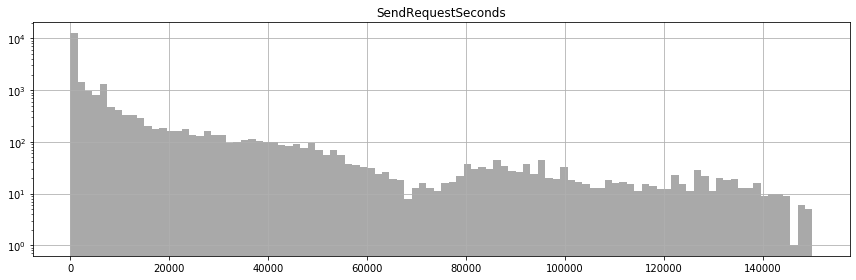

In [9]:
def SetHistoSubPlot(ax, X, bins=100, range=(1,10), ylog=False, color="blue", dfh=df, title=None):
    ax.hist(dfh[X], bins=bins, range=range, color=color)
    if not title:
        title = X
    ax.set_title(title)
    ax.grid(True)
    if ylog:
        ax.set_yscale('log')
    ax.tick_params('both')
    
# Histos    
plt.clf()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12,4))

SetHistoSubPlot(ax, "SendRequestSeconds", bins=100, range=(0, 150000), ylog=True, color="darkgrey")

# dfh = df[df['AS Number'] == '16509']
# SetHistoSubPlot(ax[1], "SendRequestSeconds", bins=50, range=(2, 3600), dfh=dfh, title="AWS 16509")

# dfh = df[df['AS Number'] == 'Unknown']
# SetHistoSubPlot(ax[2], "SendRequestSeconds", bins=50, range=(2, 3600), dfh=dfh, title="Unknown")

plt.tight_layout()
plt.show()

# Inbox Session

For each message in the contact's inbox (InboxID), there can be 1 or more requests made.
- The contact might only click on a single link and therefore only have one request
- The contact can click on multiple links and therefore will have mulitple requests

A contact with multiple requests can:
- Click the same link for all these requests
- Click a different link with each request
- A combination of the 2 above

**From a business perspective, the session is the logic unit and not the individual request**

## So we need go aggregate based on the InboxSessionID

## This also give us the advantage of having matrizable data as features!

In [10]:
df_inbox = df.groupby(['InboxSessionID']).agg({
                                                   'IPAddress':'nunique', 
                                                   'UserAgent':'nunique', 
                                                   'CIDR Range':'nunique', 
                                                   'AS Number':'nunique', 
                                                   'Link':'nunique',
                                                   'InboxID':'count',
                                                   'IPSessionID':'nunique', 
                                                   'SendRequestSeconds':'min', 
                                                   'RequestDate':lambda x: (x.max() - x.min()).seconds
                                                    })  \
                             .sort_values(['IPAddress'], ascending=False)
df_inbox.rename(columns={"IPAddress": "Unique IPs", 
                         "UserAgent": "Unique UAs", 
                         "CIDR Range": "Unique IP Ranges", 
                         "AS Number": "Unique ASNs", 
                         "AS Name": "Unique AS Names", 
                         "Link": "Unique Links Clicked",  
                         "InboxID": "Total Clicks in Session", 
                         "IPSessionID": "Unique IP Session",
                         "SendRequestSeconds": "Send to First Click",
                         "RequestDate": "Session Duration"}, 
                inplace=True)
display(df_inbox) 

,Unique IPs,Unique UAs,Unique IP Ranges,Unique ASNs,Unique Links Clicked,Total Clicks in Session,Unique IP Session,Send to First Click,Session Duration
InboxSessionID,,,,,,,,,
-3784523912976750917,40,12,3,3,37,71,40,0,0
-1397203704709772707,38,11,3,3,37,71,38,0,60
8615664337441217113,38,12,3,3,37,70,38,60,120
-6147413064966051717,38,10,3,3,37,71,38,0,0
-8040123938289544063,37,12,3,3,37,70,37,0,60
...,...,...,...,...,...,...,...,...,...
-2662101708673658021,1,1,1,1,2,2,1,114420,60
-2662047240197831019,1,1,1,1,1,1,1,2040,0
-2657231837133245745,1,1,1,1,1,1,1,3120,0


## Covariance Matrix of Sessionized Inbox Requests

In [11]:
df_inbox.corr()

,Unique IPs,Unique UAs,Unique IP Ranges,Unique ASNs,Unique Links Clicked,Total Clicks in Session,Unique IP Session,Send to First Click,Session Duration
Unique IPs,1.000000,0.462097,0.838110,0.371006,0.859668,0.885097,0.999934,-0.168545,0.109666
Unique UAs,0.462097,1.000000,0.050929,0.651306,0.340088,0.577235,0.462206,-0.023304,0.061245
Unique IP Ranges,0.838110,0.050929,1.000000,0.112956,0.766714,0.654615,0.838245,-0.179379,0.125103
Unique ASNs,0.371006,0.651306,0.112956,1.000000,0.213369,0.420035,0.371687,-0.011125,0.116472
Unique Links Clicked,0.859668,0.340088,0.766714,0.213369,1.000000,0.940926,0.859732,-0.164910,0.180898
Total Clicks in Session,0.885097,0.577235,0.654615,0.420035,0.940926,1.000000,0.885177,-0.140997,0.201350
Unique IP Session,0.999934,0.462206,0.838245,0.371687,0.859732,0.885177,1.000000,-0.168573,0.111260
Send to First Click,-0.168545,-0.023304,-0.179379,-0.011125,-0.164910,-0.140997,-0.168573,1.000000,-0.011509
Session Duration,0.109666,0.061245,0.125103,0.116472,0.180898,0.201350,0.111260,-0.011509,1.000000


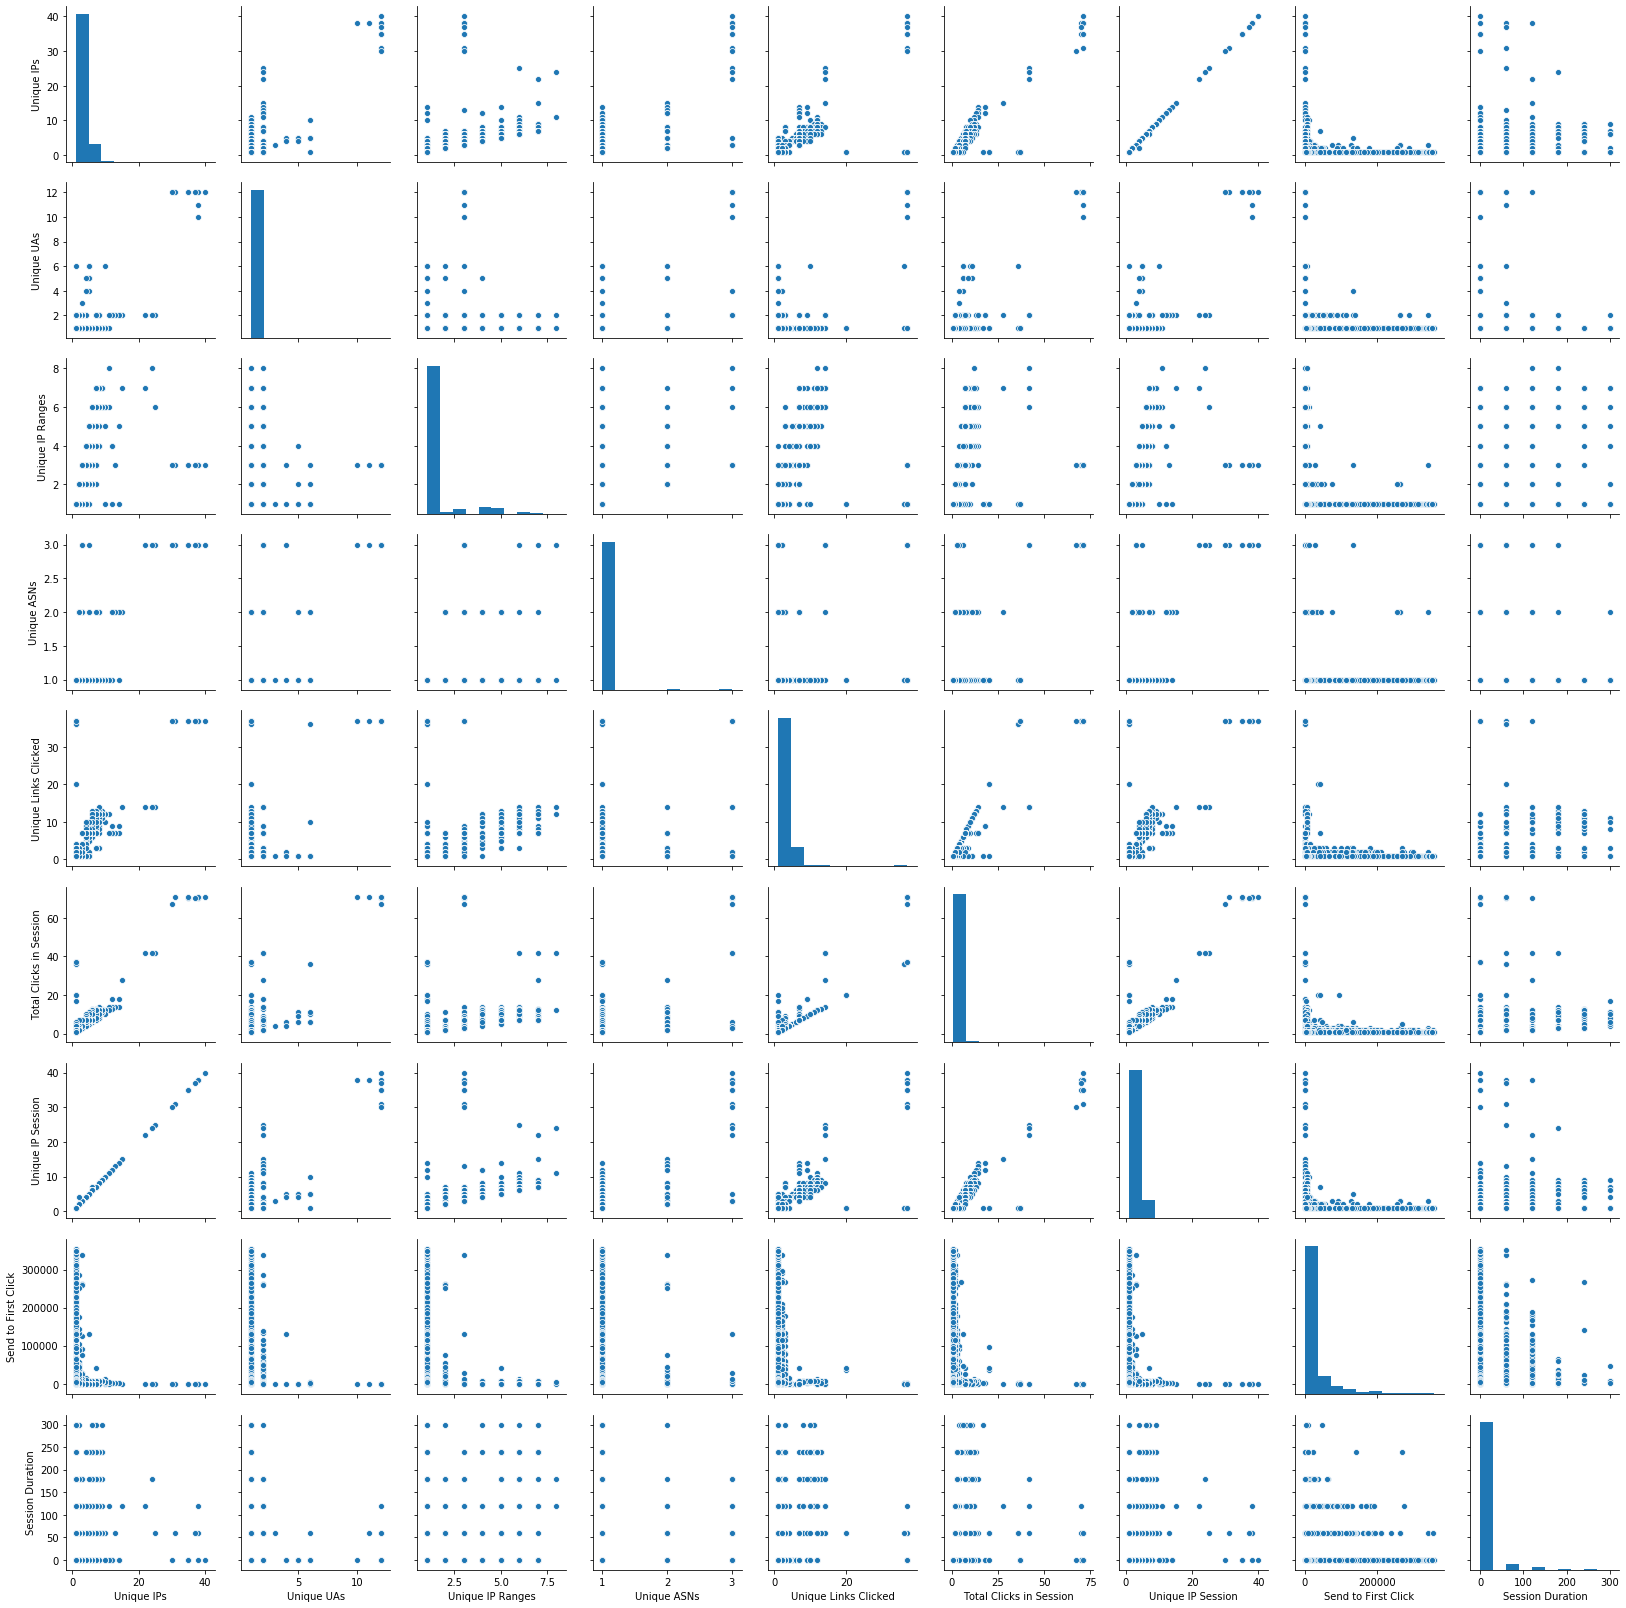

In [12]:
sns.pairplot(df_inbox)

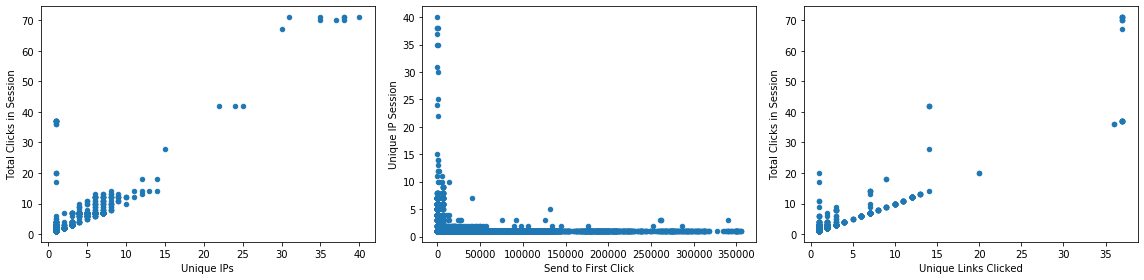

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (16,4))

df_inbox.plot( kind='scatter',
               y ="Total Clicks in Session", 
               x ="Unique IPs",
               ax=axes[0]
              )

df_inbox.plot( kind='scatter',
               y ="Unique IP Session", 
               x ="Send to First Click",
               ax=axes[1]
              )

df_inbox.plot( kind='scatter',
               y ="Total Clicks in Session", 
               x ="Unique Links Clicked",
               ax=axes[2]
              )
plt.tight_layout()
plt.show()

# Principal Component Analysis

In [14]:
variables = ["Unique IPs", 
             "Unique UAs", 
             "Unique IP Ranges", 
             "Unique ASNs", 
             "Unique Links Clicked",  
             "Total Clicks in Session", 
             "Unique IP Session",
             "Send to First Click",
             "Session Duration"]
x = df_inbox.loc[:, variables].values
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x)
x

,0,1,2,3,4,5,6,7,8
0,20.080612,32.456991,1.476962,18.801457,14.228206,22.805624,20.074915,-0.531954,-0.216987
1,19.033838,29.499155,1.476962,18.801457,14.228206,22.805624,19.028429,-0.531954,2.098164
2,19.033838,32.456991,1.476962,18.801457,14.228206,22.475393,19.028429,-0.530799,4.413316
3,19.033838,26.541319,1.476962,18.801457,14.228206,22.805624,19.028429,-0.531954,-0.216987
4,18.510451,32.456991,1.476962,18.801457,14.228206,22.475393,18.505186,-0.531954,2.098164
...,...,...,...,...,...,...,...,...,...
12393,-0.331476,-0.079206,-0.350612,-0.080719,0.062158,0.019657,-0.331553,1.670759,2.098164
12394,-0.331476,-0.079206,-0.350612,-0.080719,-0.342586,-0.310574,-0.331553,-0.492682,-0.216987
12395,-0.331476,-0.079206,-0.350612,-0.080719,-0.342586,-0.310574,-0.331553,-0.471890,-0.216987
12396,-0.331476,-0.079206,-0.350612,-0.080719,-0.342586,-0.310574,-0.331553,-0.394501,-0.216987


In [15]:

pca = PCA()
t = pca.fit_transform(x)
df_inbox_standarized = pd.DataFrame(t)
df_inbox_standarized.columns = ["Unique IPs", 
             "Unique UAs", 
             "Unique IP Ranges", 
             "Unique ASNs", 
             "Unique Links Clicked",  
             "Total Clicks in Session", 
             "Unique IP Session",
             "Send to First Click",
             "Session Duration"]
df_inbox_standarized

,Unique IPs,Unique UAs,Unique IP Ranges,Unique ASNs,Unique Links Clicked,Total Clicks in Session,Unique IP Session,Send to First Click,Session Duration
0,46.005878,26.018283,-6.359028,0.409335,9.105845,-3.464498,-3.036138,0.007151,0.001770
1,44.556359,24.481845,-3.714975,-0.398048,8.023663,-1.804921,-3.323960,0.439354,-0.000355
2,45.355377,26.359916,-1.983009,-1.437336,9.222641,-3.565532,-2.260226,-0.111582,-0.004139
3,43.614569,22.587448,-5.457517,0.632117,6.719575,-0.171561,-4.360020,0.744931,0.002825
4,44.687789,26.351624,-4.047541,-0.699088,9.288651,-2.989800,-1.726418,0.072313,-0.001470
...,...,...,...,...,...,...,...,...,...
12393,-0.386165,0.530833,2.566091,0.687541,0.239986,0.055440,-0.022516,-0.062292,-0.002400
12394,-0.706515,0.021196,-0.355352,-0.481443,0.033654,0.008632,-0.015367,0.006613,0.000150
12395,-0.708408,0.025730,-0.348046,-0.462613,0.033286,0.008492,-0.015277,0.006541,0.000150
12396,-0.715457,0.042603,-0.320854,-0.392520,0.031915,0.007968,-0.014941,0.006274,0.000152


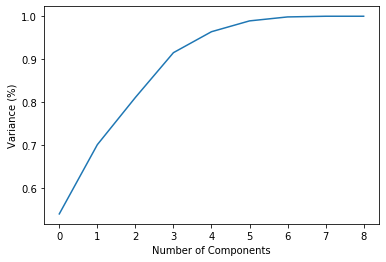

In [16]:
fit = pca.fit(df_inbox_standarized)
plt.figure()
plt.plot(np.cumsum(fit.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.show()

In [17]:
pca_5 = PCA(n_components=5)
df_inbox_reduced = pca_5.fit_transform(df_inbox_standarized)
df_inbox_reduced = pd.DataFrame(df_inbox_reduced)
df_inbox_reduced

,0,1,2,3,4
0,46.005878,26.018283,-6.359028,0.409335,9.105845
1,44.556359,24.481845,-3.714975,-0.398048,8.023663
2,45.355377,26.359916,-1.983009,-1.437336,9.222641
3,43.614569,22.587448,-5.457517,0.632117,6.719575
4,44.687789,26.351624,-4.047541,-0.699088,9.288651
...,...,...,...,...,...
12393,-0.386165,0.530833,2.566091,0.687541,0.239986
12394,-0.706515,0.021196,-0.355352,-0.481443,0.033654
12395,-0.708408,0.025730,-0.348046,-0.462613,0.033286
12396,-0.715457,0.042603,-0.320854,-0.392520,0.031915


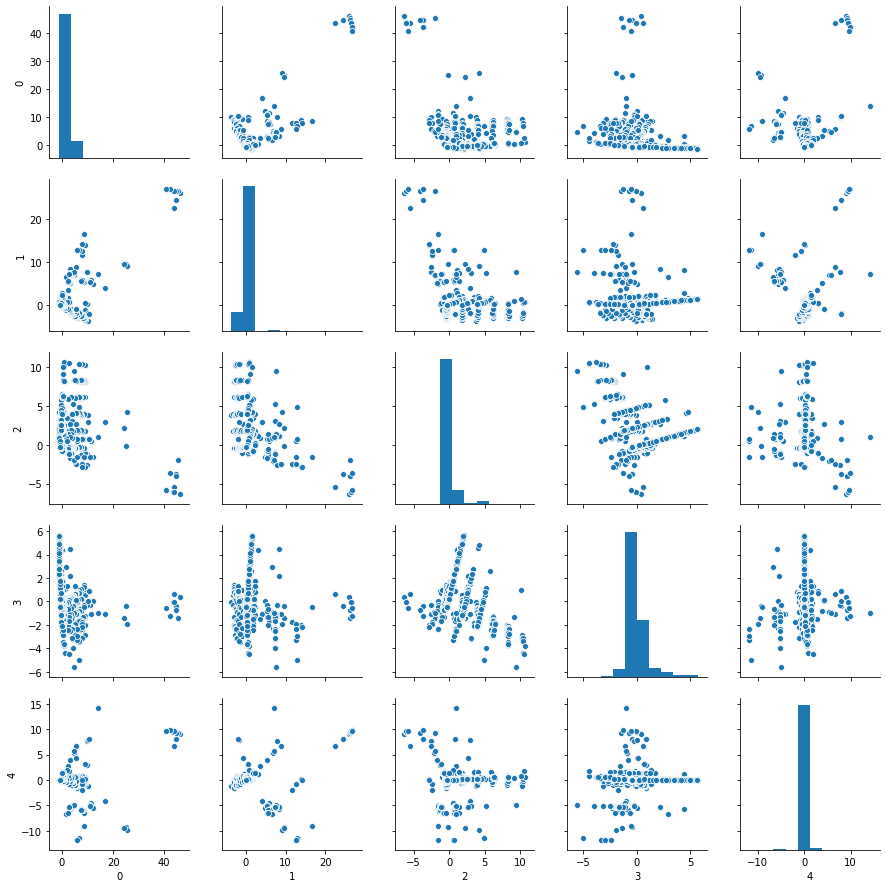

In [18]:
sns.pairplot(df_inbox_reduced)